In [110]:
import wandb
import yaml
from utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [561]:
dataset = "mnist"
#[0, 1, 2, 4, 5, -1]
#[8, 7, 3, 9, 6, -1]
first_class = 4
second_class = 9
sweep_config = "default"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size', 'validation_error', 'test_error']

In [562]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
size_hyperparams = tuple([len(l) for l in hps.values()])

In [563]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset + str(first_class) + str(second_class)
runs = api.runs(entity + "/" + project)

In [564]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    for val_to_fetch_idx in range(len(values_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = values_to_fetch[val_to_fetch_idx]
        results_matrix[matrix_idx] = run.summary[val_to_fetch]

In [565]:
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

def different_length_means(list_of_list):
    mean_list = []
    for idx in range(max([len(l) for l in list_of_list])):
        count = 0
        somme = 0
        for l in list_of_list:
            if len(l) > idx:
                somme += l[idx]
                count += 1
        mean_list.append(somme/count)
    return np.array(mean_list)

In [566]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.224476,0.224062,0.068970,674.8,0.011565,0.011379
mlp 0.1 0.001,0.167632,0.167198,0.046221,445.2,0.010249,0.011511
mlp 0.1 0.005,0.177014,0.176583,0.049706,480.2,0.010892,0.011775
mlp 0.1 0.0001,0.154836,0.154396,0.041627,399.2,0.011124,0.011398
mlp 0.2 0.01,0.228788,0.228376,0.070712,692.4,0.013163,0.011743
mlp 0.2 0.001,0.162551,0.162114,0.044347,426.4,0.011010,0.010216
mlp 0.2 0.005,0.176842,0.176411,0.049665,479.8,0.011683,0.010896
mlp 0.2 0.0001,0.144096,0.143653,0.037846,361.4,0.011862,0.010427
cnn 0.1 0.01,0.169415,0.168981,0.047547,459.0,0.006314,0.007858
cnn 0.1 0.001,0.105158,0.104699,0.025300,237.0,0.008162,0.007712


In [567]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)

std_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.017215,0.017221,0.007488,75.961569,0.002762,0.001575
mlp 0.1 0.001,0.006531,0.006533,0.002401,24.086511,0.002502,0.000903
mlp 0.1 0.005,0.005592,0.005594,0.002099,21.094075,0.000918,0.001807
mlp 0.1 0.0001,0.008939,0.008942,0.003175,31.764131,0.000973,0.001249
mlp 0.2 0.01,0.009418,0.009422,0.004067,41.243666,0.002755,0.002876
mlp 0.2 0.001,0.001647,0.001647,0.000594,5.953150,0.002201,0.001419
mlp 0.2 0.005,0.008690,0.008693,0.003288,33.053895,0.002402,0.001269
mlp 0.2 0.0001,0.000543,0.000543,0.000186,1.854724,0.003303,0.001008
cnn 0.1 0.01,0.035909,0.035923,0.014277,144.019443,0.002216,0.001676
cnn 0.1 0.001,0.003735,0.003737,0.001123,11.045361,0.001118,0.001745


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_2611/476667532.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


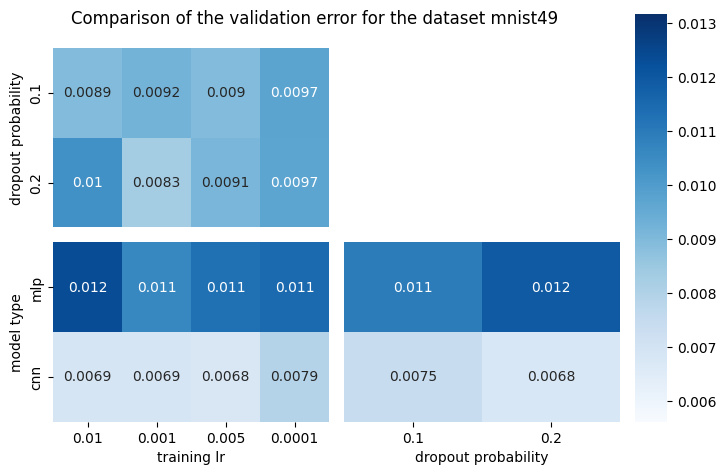

In [568]:
mean_arr = results_matrix.mean(1)
index = 4

fig, axs = plt.subplots(2, 2)
fig.delaxes(axs[0, 1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])

cmap = 'Blues'
vmax = mean_arr[index].max()
vmin = mean_arr[index].min()

lr_mt_arr = pd.DataFrame(mean_arr.mean(2)[index,:,:], index=hps['model_type'], columns=hps['training_lr'])
lr_dp_arr = pd.DataFrame(mean_arr.mean(1)[index,:,:], index=hps['dropout_probability'], columns=hps['training_lr'])
dp_mt_arr = pd.DataFrame(mean_arr.mean(3)[index,:,:], index=hps['model_type'], columns=hps['dropout_probability'])

sn.heatmap(lr_dp_arr, annot=True,ax=axs[0,0],xticklabels=False, cbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,0].set(ylabel="dropout probability")

sn.heatmap(lr_mt_arr, annot=True, ax=axs[1,0], cbar=False, cmap=cmap, vmin=vmin, vmax=vmax,)
axs[1,0].set(xlabel="training lr", ylabel="model type")

sn.heatmap(dp_mt_arr,annot=True, ax=axs[1,1], yticklabels=False, cbar=True, cmap=cmap, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,)
axs[1,1].set(xlabel="dropout probability")


fig.suptitle(f"Comparison of the {values_to_fetch[index].replace('_', ' ')} for the dataset {dataset + str(first_class) + str(second_class)}")
# Layout so plots do not overlap
fig.tight_layout()

plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_{values_to_fetch[index]}_heatmaps.jpg",bbox_inches='tight')

In [569]:
val_of_interest = "kl_bound"
model_type, dropout_probability, training_lr = correct_type_of_entry(mean_df.index[mean_df[val_of_interest].argmin()].split())

print("model type :", model_type, "dropout probability :", dropout_probability, "learning rate :", training_lr)

best_val_arr = mean_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
std_val_arr = std_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
print(f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ')

model type : cnn dropout probability : 0.1 learning rate : 0.001
Validation error: 0.0082±0.0011 Test error : 0.0077±0.0017  KL bound : 0.1052±0.0037  binomial : 0.1047±0.0037  P2L bound : 0.0253±0.0011  compression set size : 237.0000±11.0454 


model type : cnn dropout probability : 0.2 learning rate : 0.005
Validation error: 0.0038719211239367723 KL bound : 0.08170091081410646 compression set size : 163.8 Test error : 0.004795903572812676 P2L bound : 0.018529182736434363 binomial : 0.08121609313096387
The best bound for run 42 happens at 100 datapoints with a bound value of 0.07343133388057727
The best bound for run 4 happens at 90 datapoints with a bound value of 0.05979982487249466
The best bound for run 3 happens at 90 datapoints with a bound value of 0.058029788301369595
The best bound for run 2 happens at 110 datapoints with a bound value of 0.066071298009694
The best bound for run 1 happens at 110 datapoints with a bound value of 0.0654245711935734
Mean value of the best bounds taken separately : 0.06455136325154179
Mean value of the compression size of best bounds : 100.0


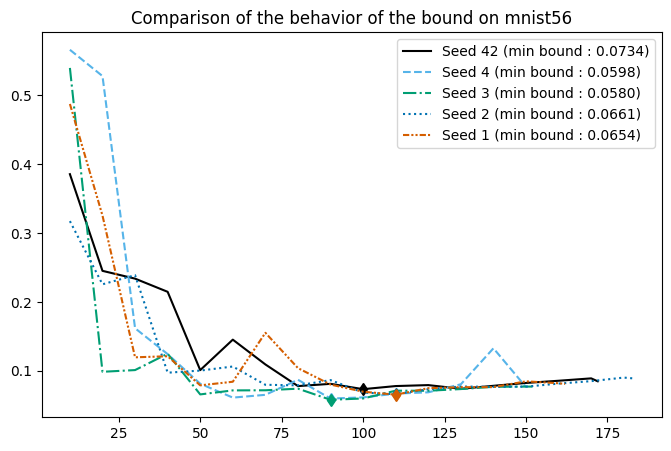

In [489]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
colors = ["#000000", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]

plt.figure(figsize=(8,5))
run_list = []

for run in runs:
    if run.config['model_type'] == model_type:
        if run.config['training_lr'] == training_lr:
            if run.config['dropout_probability'] == dropout_probability:
                run_list.append(run)

all_seeds_bounds = []
max_length_run = 0
max_comp_sizes = []
counter = 0
best_comp_set_size = []
for run in run_list:
    history = run.scan_history(keys=["complement_error"])
    losses = [row["complement_error"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(losses)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])

    if compression_sizes.shape[0] > max_length_run:
        max_length_run = compression_sizes.shape[0]
        max_comp_sizes = compression_sizes
        
    bound_list = []
    for idx in range(len(losses)):
        epsilon = compute_epsilon(compression_sizes[idx], 1, run.summary['train_set_size'], run.config['delta'])
        bound = kl_bound(compression_sizes[idx], run.summary['train_set_size'], float(losses[idx]), epsilon)
        bound_list.append(bound)
    plt.plot(compression_sizes, bound_list,'d',
             markevery=[np.array(bound_list).argmin()],
             linestyle=linestyles[counter], #ms=8, #mew=1.2,
             color=colors[counter],
             label=f"Seed {run.config['seed']} (min bound : {min(bound_list):.4f})")
    best_idx = np.array(bound_list).argmin()
    best_comp_set_size.append(compression_sizes[best_idx])
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {bound_list[best_idx]}")
    all_seeds_bounds.append(bound_list)
    counter += 1

print(f"Mean value of the best bounds taken separately : {sum([min(l) for l in all_seeds_bounds])/5}")
print(f"Mean value of the compression size of best bounds : {sum(best_comp_set_size)/5}")
plt.legend(markerscale=0)
plt.title(f"Comparison of the behavior of the bound on {dataset + str(first_class) + str(second_class)}")
plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_min_bound_comparison.jpg")


In [440]:
run_list

[<Run mathieu-bazinet/sweepmnist08/44d3dupm (finished)>,
 <Run mathieu-bazinet/sweepmnist08/ijhn43n6 (finished)>,
 <Run mathieu-bazinet/sweepmnist08/qk0inlbr (finished)>,
 <Run mathieu-bazinet/sweepmnist08/xtwiwa2b (finished)>,
 <Run mathieu-bazinet/sweepmnist08/v1qlt06g (finished)>]

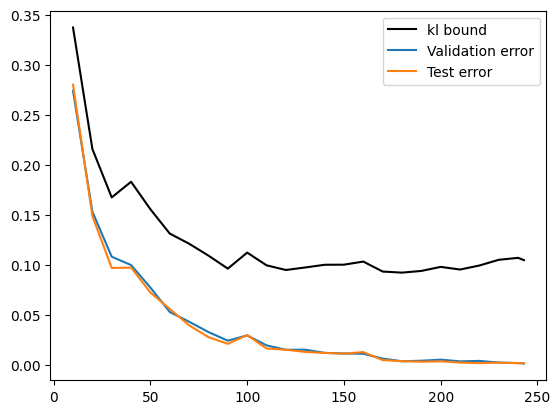

In [36]:
plt.plot(max_comp_sizes, mean_bounds, color="black", label="kl bound")
test_errors = []
val_errors = []
for run in run_list:
    # TO BE REMOVED
    if dataset + str(first_class) + str(second_class) == "mnist49":
        history = run.scan_history(keys=["test_results"])
        test_error = [row["test_results"] for row in history]
        test_error.append(run.summary['test_error'])
        test_errors.append(test_error)
    
    history = run.scan_history(keys=["test_error"])
    test_error = [row["test_error"] for row in history]
    test_errors.append(test_error)
    
    history = run.scan_history(keys=["val_error"])
    val_error = [row["val_error"] for row in history]
    if len(val_error) != len(test_error):
        val_error.append(run.summary['validation_error'])
    val_errors.append(val_error)


mean_val = different_length_means(val_errors)
mean_test = different_length_means(test_errors)
plt.plot(max_comp_sizes, mean_val, label="Validation error")
plt.plot(max_comp_sizes, mean_test, label="Test error")
plt.legend()
plt.show()